In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

### Establishing baseline w.r.t PCA

ncomp -> 50, lr -> 0.001, wd -> 0.05, nparams -> 6619186
Time taken for fitting with 30 epochs: 0:04:43.255647
Time taken to transform: 23.56
Reconstruction error: 17.841055


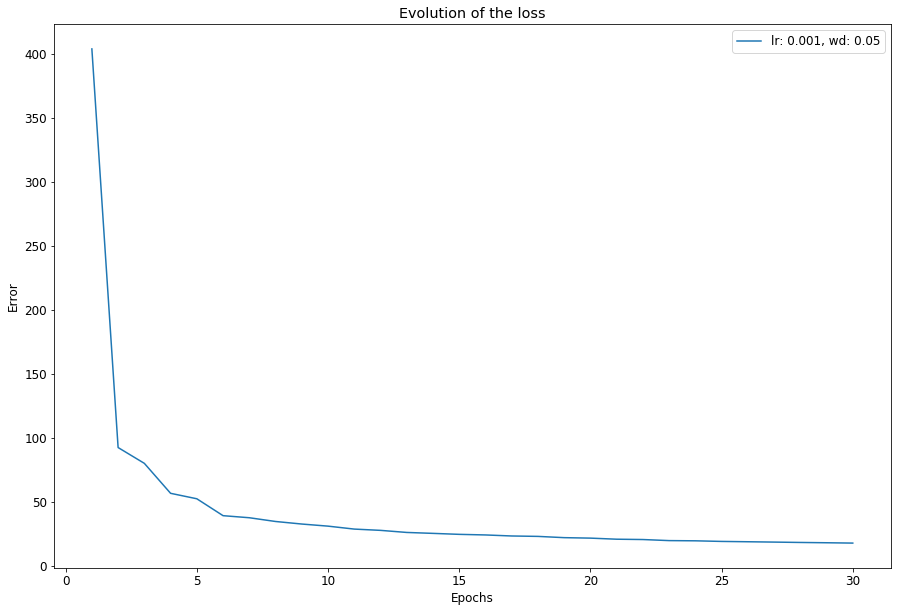

In [15]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, grayscale=True)
net = PCAAutoEncoder((video.width, video.height), ncomp)
lr, wd, num_epoch = 0.001, 0.05, 30 # Tuned hyper-parameters
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')


start = time()
losses = []
for i in range(num_epoch):
    epoch_loss = 0
    num_batch  = 0
    for x in video:
        num_batch += 1
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss / num_batch)
fitting_time = sec2string(time() - start)

video.randit = video.skip_frame = 0
start = time()

reconstructed = []
for x in video:
    x = torch.from_numpy(x).float()
    reconstructed.append(net(x).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = sec2string(time() - start)

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
      
print(f'Time taken for fitting with {num_epoch} epochs:', fitting_time)
print('Time taken to transform:', transform_time)

print('Reconstruction error:', exact_loss)
losses = np.array(losses)
plot(range(1, num_epoch+1), [losses], title='Evolution of the loss', xlabel='Epochs', ylabel='Error', labels=['lr: 0.001, wd: 0.05'])

As a comparison for PCA:
Error of 7.45 after 36s of fitting time

In [16]:
write_video('data/big_sample_pcaae_50.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)

## Adding layers

### One-hidden

ncomp -> 50, lr -> 0.0005, wd -> 0.01, nparams -> 26300386
Time taken for fitting with 30 epochs: 8:52
Time taken to transform: 28.68
Reconstruction error: 14.618819236755371


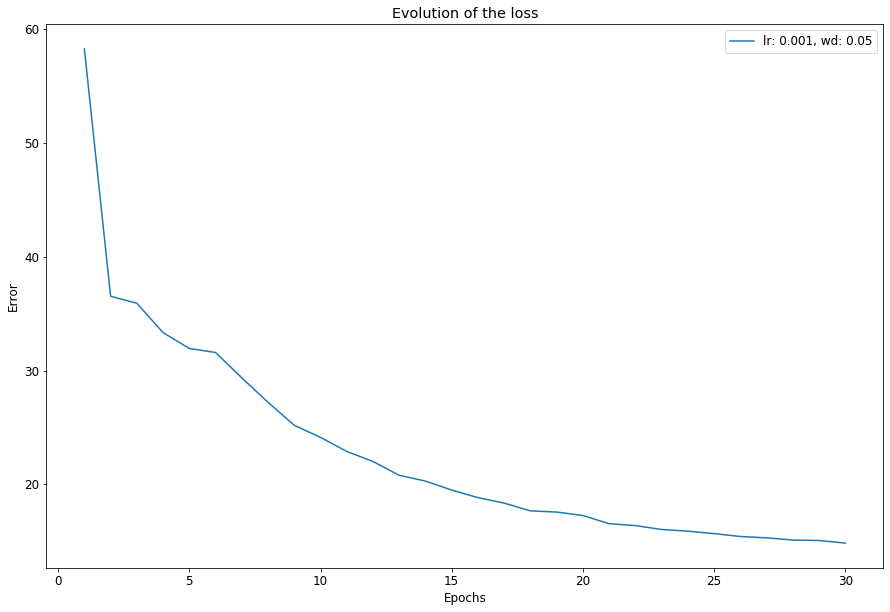

In [3]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, gray=True)
net = OneAutoEncoder((video.width, video.height), ncomp)
lr, wd, num_epoch = 0.0005, 0.01, 30
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')

start = time()
losses = []
for i in range(num_epoch):
    epoch_loss = 0
    num_batch  = 0
    for x in video:
        num_batch += 1
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()
    
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss / num_batch)
fitting_time = sec2string(time() - start)
start = time()
reconstructed = video.reduce_latent(net)
transform_time = sec2string(time() - start)

exact_loss = crit(reconstructed, video.get_all_frames()).item()
      
print(f'Time taken for fitting with {num_epoch} epochs:', fitting_time)
print('Time taken to transform:', transform_time)

print('Reconstruction error:', exact_loss)
losses = np.array(losses)
plot(range(1, num_epoch+1), [losses], title='Evolution of the loss', xlabel='Epochs', ylabel='Error', labels=['lr: 0.001, wd: 0.05'])epoch_loss

### Trying convolutions

In [14]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, gray=True)

wd = 0.0001
num_epoch = 3
for lr in [0.001, 0.0001]:
    
    net = SpatialConvAE(1, ncomp)
    optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
    print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')

    start = time()
    losses = []
    for i in range(num_epoch):
        epoch_loss = 0
        num_batch  = 0
        for x in video:
            num_batch += 1
            x_reconstructed = net(x)
            batch_loss = crit(x_reconstructed, x)
            epoch_loss += batch_loss.item()
        
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            print(batch_loss)
        losses.append(epoch_loss / num_batch)
        print('Error %d' % (i+1), losses[-1])
            
fitting_time = sec2string(time() - start)

ncomp -> 50, lr -> 0.001, wd -> 0.0001, nparams -> 5142131
tensor(63.2664, grad_fn=<SqrtBackward>)
tensor(51.7119, grad_fn=<SqrtBackward>)
tensor(1339.3649, grad_fn=<SqrtBackward>)
tensor(42.2812, grad_fn=<SqrtBackward>)
tensor(60.8316, grad_fn=<SqrtBackward>)
tensor(67.4229, grad_fn=<SqrtBackward>)
tensor(61.5178, grad_fn=<SqrtBackward>)
tensor(56.6071, grad_fn=<SqrtBackward>)
tensor(72.8829, grad_fn=<SqrtBackward>)
tensor(57.2514, grad_fn=<SqrtBackward>)
tensor(63.4964, grad_fn=<SqrtBackward>)
tensor(57.6112, grad_fn=<SqrtBackward>)
tensor(67.1282, grad_fn=<SqrtBackward>)
tensor(58.6561, grad_fn=<SqrtBackward>)
tensor(60.7662, grad_fn=<SqrtBackward>)
tensor(61.6896, grad_fn=<SqrtBackward>)
tensor(66.8713, grad_fn=<SqrtBackward>)
tensor(68.0746, grad_fn=<SqrtBackward>)
tensor(59.9748, grad_fn=<SqrtBackward>)
tensor(68.7298, grad_fn=<SqrtBackward>)
tensor(56.9420, grad_fn=<SqrtBackward>)
tensor(59.7923, grad_fn=<SqrtBackward>)
tensor(63.0737, grad_fn=<SqrtBackward>)
tensor(49.5505, gra

# TRASH

In [17]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, grayscale=True)
net = PCAAutoEncoder((video.width, video.height), ncomp)
lr, wd, num_epoch = 0.001, 0.05, 30 # Tuned hyper-parameters
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')


start = time()
losses = []
for i in range(num_epoch):
    epoch_loss = 0
    num_batch  = 0
    for x in video:
        num_batch += 1
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss / num_batch)
fitting_time = sec2string(time() - start)

ncomp -> 50, lr -> 0.001, wd -> 0.05, nparams -> 6619186
torch.Size([64, 256, 256])


TypeError: expected np.ndarray (got Tensor)